# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


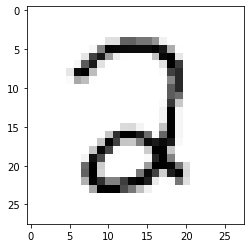

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2594
Training Accuracy: 0.6121, Testing Accuracy: 0.6064



Epoch 10, Loss 0.0786
Training Accuracy: 0.9244, Testing Accuracy: 0.9345



Epoch 20, Loss 0.051
Training Accuracy: 0.9476, Testing Accuracy: 0.9516



Epoch 30, Loss 0.0409
Training Accuracy: 0.9551, Testing Accuracy: 0.9592



Epoch 40, Loss 0.0357
Training Accuracy: 0.9601, Testing Accuracy: 0.9652



Epoch 50, Loss 0.0324
Training Accuracy: 0.9635, Testing Accuracy: 0.9667



Epoch 60, Loss 0.0301
Training Accuracy: 0.9660, Testing Accuracy: 0.9667



Epoch 70, Loss 0.0284
Training Accuracy: 0.9679, Testing Accuracy: 0.9667



Epoch 80, Loss 0.027
Training Accuracy: 0.9688, Testing Accuracy: 0.9682



Epoch 90, Loss 0.0258
Training Accuracy: 0.9701, Testing Accuracy: 0.9682



Epoch 100, Loss 0.0249
Training Accuracy: 0.9713, Testing Accuracy: 0.9682



Epoch 110, Loss 0.024
Training Accuracy: 0.9726, Testing Accuracy: 0.9698



Epoch 120, Loss 0.0233
Training Accuracy: 0.9729, Testing Accuracy: 0.9703



Epoch 130, Loss 0.0226
Training Accuracy: 0.9737, Testing Accuracy: 0.9708



Epoch 140, Loss 0.022
Training Accuracy: 0.9746, Testing Accuracy: 0.9723



Epoch 150, Loss 0.0214
Training Accuracy: 0.9755, Testing Accuracy: 0.9728



Epoch 160, Loss 0.0209
Training Accuracy: 0.9762, Testing Accuracy: 0.9723



Epoch 170, Loss 0.0204
Training Accuracy: 0.9773, Testing Accuracy: 0.9718



Epoch 180, Loss 0.0199
Training Accuracy: 0.9783, Testing Accuracy: 0.9728



Epoch 190, Loss 0.0195
Training Accuracy: 0.9787, Testing Accuracy: 0.9733



Epoch 200, Loss 0.0191
Training Accuracy: 0.9791, Testing Accuracy: 0.9733



Epoch 210, Loss 0.0187
Training Accuracy: 0.9796, Testing Accuracy: 0.9738



Epoch 220, Loss 0.0183
Training Accuracy: 0.9802, Testing Accuracy: 0.9738



Epoch 230, Loss 0.0179
Training Accuracy: 0.9804, Testing Accuracy: 0.9743



Epoch 240, Loss 0.0176
Training Accuracy: 0.9809, Testing Accuracy: 0.9743



0.02423104329132244

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2131
Training Accuracy: 0.8071, Testing Accuracy: 0.8145



Epoch 10, Loss 0.0981
Training Accuracy: 0.9163, Testing Accuracy: 0.9289



Epoch 20, Loss 0.0772
Training Accuracy: 0.9293, Testing Accuracy: 0.9446



Epoch 30, Loss 0.0673
Training Accuracy: 0.9367, Testing Accuracy: 0.9491



Epoch 40, Loss 0.0611
Training Accuracy: 0.9419, Testing Accuracy: 0.9501



Epoch 50, Loss 0.0569
Training Accuracy: 0.9453, Testing Accuracy: 0.9556



Epoch 60, Loss 0.0537
Training Accuracy: 0.9469, Testing Accuracy: 0.9572



Epoch 70, Loss 0.0512
Training Accuracy: 0.9489, Testing Accuracy: 0.9587



Epoch 80, Loss 0.0492
Training Accuracy: 0.9507, Testing Accuracy: 0.9597



Epoch 90, Loss 0.0476
Training Accuracy: 0.9517, Testing Accuracy: 0.9597



Epoch 100, Loss 0.0462
Training Accuracy: 0.9531, Testing Accuracy: 0.9622



Epoch 110, Loss 0.045
Training Accuracy: 0.9540, Testing Accuracy: 0.9632



Epoch 120, Loss 0.0439
Training Accuracy: 0.9551, Testing Accuracy: 0.9632



Epoch 130, Loss 0.043
Training Accuracy: 0.9559, Testing Accuracy: 0.9637



Epoch 140, Loss 0.0422
Training Accuracy: 0.9560, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0414
Training Accuracy: 0.9565, Testing Accuracy: 0.9642



Epoch 160, Loss 0.0407
Training Accuracy: 0.9567, Testing Accuracy: 0.9647



Epoch 170, Loss 0.0401
Training Accuracy: 0.9569, Testing Accuracy: 0.9662



Epoch 180, Loss 0.0396
Training Accuracy: 0.9579, Testing Accuracy: 0.9672



Epoch 190, Loss 0.0391
Training Accuracy: 0.9588, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0386
Training Accuracy: 0.9594, Testing Accuracy: 0.9672



Epoch 210, Loss 0.0381
Training Accuracy: 0.9596, Testing Accuracy: 0.9677



Epoch 220, Loss 0.0377
Training Accuracy: 0.9600, Testing Accuracy: 0.9682



Epoch 230, Loss 0.0373
Training Accuracy: 0.9604, Testing Accuracy: 0.9682



Epoch 240, Loss 0.037
Training Accuracy: 0.9605, Testing Accuracy: 0.9688



0.010063099447289434

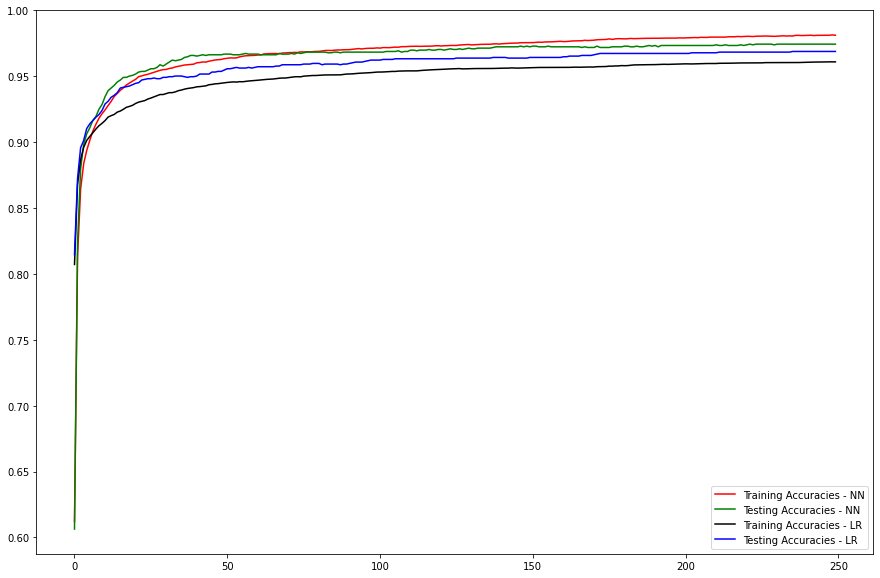

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

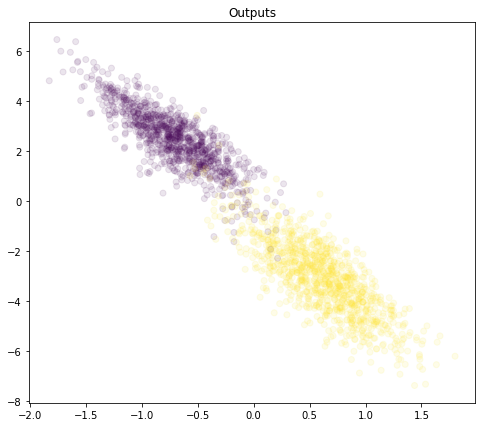

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

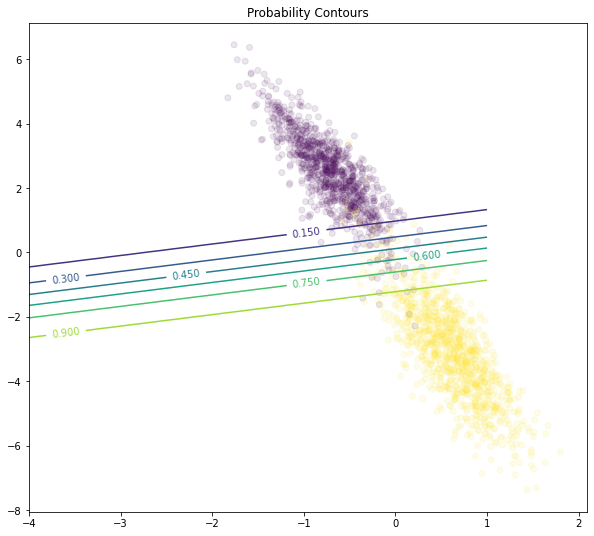

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );